In [2]:
import numpy as np
import pandas as pd
import json

%matplotlib inline

import matplotlib.pyplot as plt
from plotnine import *

from scipy.stats import linregress
import seaborn as sns

1.Data clean

In [86]:
#Choose CA for health dataset
health = pd.read_csv('500_Cities__Census_Tract-level_Data__GIS_Friendly_Format___2018_release.csv')
health = health[health['StateAbbr'] == 'CA']

In [87]:
#Get the infromation we need
health_needed = health[['Place_TractID','PlaceName','BPHIGH_CrudePrev','CASTHMA_CrudePrev','COPD_CrudePrev',
           'CSMOKING_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','MHLTH_CrudePrev','SLEEP_CrudePrev']]

#Get the population weight for each disease percentage.
population_total = health[['PlaceName','Population2010']]
population_total= population_total.groupby(['PlaceName']).sum().reset_index()
population_total = population_total.rename(columns = {population_total.columns[1]: "Total Population"})
population_each = health[['Place_TractID','PlaceName','Population2010']]
population_proportion = pd.merge(population_each,population_total , on = 'PlaceName')
population_proportion['Population weight'] = population_proportion['Population2010']/population_proportion['Total Population']
population_weight = population_proportion[['Place_TractID','Population weight']]
health_needed = pd.merge(health_needed,population_weight , on = 'Place_TractID')

In [88]:
#Get the weighted average of each disease
for i in range(8):
    health_needed.iloc[:,i+2] = health_needed.iloc[:,i+2]*health_needed.iloc[:,10]
health_needed = health_needed.iloc[:,1:9]
health_needed= health_needed.groupby(['PlaceName']).sum().reset_index()

In [89]:
#Read the pollution dataset
pollution = pd.read_excel('ces3results.xlsx',sheet_name='CES 3.0 (2018 Update)')

In [90]:
#Choose the information we need and get the mean of each pollution for each city.
pollution_needed = pollution[['Nearby City \n(to help approximate location only)',
                             'CES 3.0 Score','Ozone','PM2.5','Diesel PM','Drinking Water',
                              'Pesticides','Tox. Release','Traffic','Haz. Waste',
                              'Imp. Water Bodies','Solid Waste','Pollution Burden Score']]
pollution_needed = pollution_needed.rename(columns = {pollution_needed.columns[0]: "PlaceName"})
pollution_needed = pollution_needed.groupby(['PlaceName']).mean().reset_index()

In [91]:
information = pd.merge(health_needed, pollution_needed, on = 'PlaceName')

1.Get disease rate

In [92]:
#Get disease rate of asthma and COPD
asthma = information.sort_values('CASTHMA_CrudePrev')

COPD = information.sort_values('COPD_CrudePrev')

In [94]:
#get cities that both have low disease rate of of asthma and COPD
list(set(asthma.head(8)['PlaceName']).intersection(COPD.head(8)['PlaceName']))

['Fremont', 'Santa Clara', 'Sunnyvale', 'Milpitas', 'San Ramon']

In [106]:
#get cities that both have high disease rate of of asthma and COPD
list(set(asthma.tail(10)['PlaceName']).intersection(COPD.tail(11)['PlaceName']))

['Apple Valley', 'Hesperia', 'San Bernardino', 'Citrus Heights', 'Victorville']

In [119]:
#get cities that both have high disease rate of diabetes
Diabetes = information.sort_values('DIABETES_CrudePrev')

In [120]:
#get cities that both have low disease rate of of Diabetes
list(Diabetes.head(5)['PlaceName'])

['Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine']

In [121]:
#get cities that both have high disease rate of Diabetes
list(Diabetes.tail(5)['PlaceName'])

['Westminster', 'Inglewood', 'San Bernardino', 'Compton', 'Hemet']

In [131]:
#Get disease rate of mental health
mental_health = information.sort_values('MHLTH_CrudePrev')

In [132]:
#get cities that have low disease rate of mental health
list(mental_health.head(5)['PlaceName'])

['San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont', 'Milpitas']

In [133]:
#get cities that have high disease rate of mental health
list(mental_health.tail(5)['PlaceName'])

['Hesperia', 'Merced', 'Compton', 'Lynwood', 'San Bernardino']

Then we can get these cities from the dataframe to see the how different is the diseases rate in high risk area and low risk area.

In [117]:
#Get the high risk and low risk area of asthma and COPD
asthma_and_COPD = information[information['PlaceName'].isin(['Fremont', 'Santa Clara', 'Sunnyvale', 'Milpitas', 'San Ramon',
                                                            'Apple Valley', 'Hesperia', 'San Bernardino', 
                                                             'Citrus Heights', 'Victorville'])][['CASTHMA_CrudePrev','COPD_CrudePrev','PlaceName']]
asthma_and_COPD = asthma_and_COPD.rename(columns = {asthma_and_COPD.columns[0]: "asthma",
                                                    asthma_and_COPD.columns[1]: "COPD"})

#Stack data and clean the data
asthma_and_COPD = asthma_and_COPD.set_index(['PlaceName'])
stacked = asthma_and_COPD .stack()
stacked.index.set_names('disease type', level=len(stacked.index.names)-1, inplace=True)
asthma_and_COPD = stacked.reset_index()
asthma_and_COPD = asthma_and_COPD.rename(columns = {asthma_and_COPD.columns[2]: "percentage"})


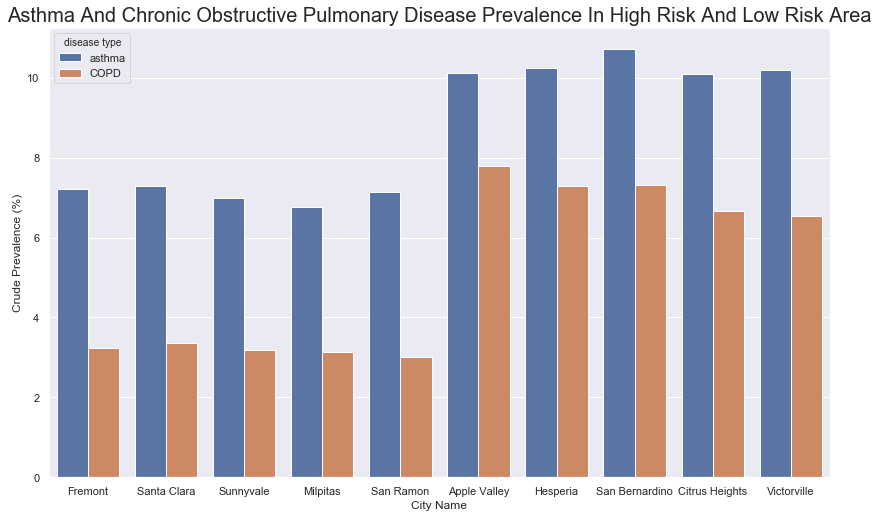

In [118]:
sns.set(rc={'figure.figsize':(14,8.27)})
p8 = sns.barplot(data = asthma_and_COPD, x = "PlaceName", y="percentage", hue = 'disease type',
                 order = ['Fremont', 'Santa Clara', 'Sunnyvale', 'Milpitas', 'San Ramon',
                                                            'Apple Valley', 'Hesperia', 'San Bernardino', 
                                                             'Citrus Heights', 'Victorville'])
p8.set_title('Asthma And Chronic Obstructive Pulmonary Disease Prevalence In High Risk And Low Risk Area',fontsize = 20)
p8.set_xlabel("City Name")
p8.set_ylabel('Crude Prevalence (%)')
fig8 = p8.get_figure()
fig8.savefig('asthma_and_COPD diabetes.png')

In [127]:
#Get the high risk and low risk area of Diabetes
Diabetes = information[information['PlaceName'].isin(['Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine',
                                                            'Westminster', 'Inglewood', 'San Bernardino', 
                                                             'Compton', 'Hemet' ])][['DIABETES_CrudePrev','PlaceName']]

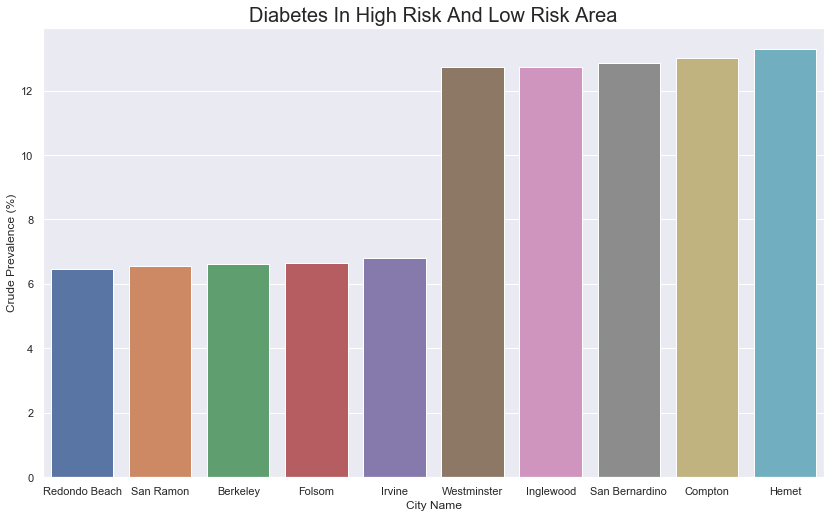

In [130]:
sns.set(rc={'figure.figsize':(14,8.27)})
p8 = sns.barplot(data = Diabetes, x = "PlaceName", y="DIABETES_CrudePrev",
                 order = ['Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine',
                                                            'Westminster', 'Inglewood', 'San Bernardino', 
                                                             'Compton', 'Hemet' ])
p8.set_title('Diabetes In High Risk And Low Risk Area',fontsize = 20)
p8.set_xlabel("City Name")
p8.set_ylabel('Crude Prevalence (%)')
fig8 = p8.get_figure()
fig8.savefig('diabetes.png')

In [135]:
#Get the high risk and low risk area of mental health problem
mental = information[information['PlaceName'].isin(['San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont', 'Milpitas',
                         'Hesperia', 'Merced', 'Compton', 'Lynwood', 'San Bernardino'])][['MHLTH_CrudePrev','PlaceName']]

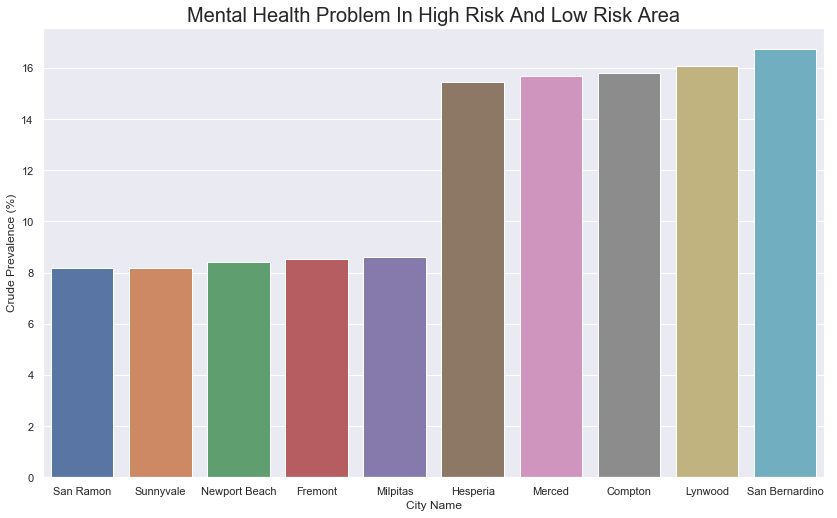

In [136]:
sns.set(rc={'figure.figsize':(14,8.27)})
p8 = sns.barplot(data = mental, x = "PlaceName", y="MHLTH_CrudePrev",
                 order = ['San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont', 'Milpitas',
                         'Hesperia', 'Merced', 'Compton', 'Lynwood', 'San Bernardino'])
p8.set_title('Mental Health Problem In High Risk And Low Risk Area',fontsize = 20)
p8.set_xlabel("City Name")
p8.set_ylabel('Crude Prevalence (%)')
fig8 = p8.get_figure()
fig8.savefig('mental diabetes.png')

Now, we can see the relationship between polution and diease

In [137]:
#Relation between the polution and asthma
linregress(information['CASTHMA_CrudePrev'],information['CES 3.0 Score'])

LinregressResult(slope=5.4462562329864745, intercept=-18.97459540605058, rvalue=0.38967966751109845, pvalue=1.0862981988729268e-05, stderr=1.1849106180749382)

In [138]:
linregress(information['CASTHMA_CrudePrev'],information['Ozone'])

LinregressResult(slope=0.0046769677673804836, intercept=0.00752935498130608, rvalue=0.38025042865045516, pvalue=1.83652475959281e-05, stderr=0.0010472267418643493)

In [139]:
linregress(information['CASTHMA_CrudePrev'],information['PM2.5'])

LinregressResult(slope=-0.0009654859265285544, intercept=10.342271029296366, rvalue=-0.0003464951319688204, pvalue=0.9970032046227674, stderr=0.2565120553052778)

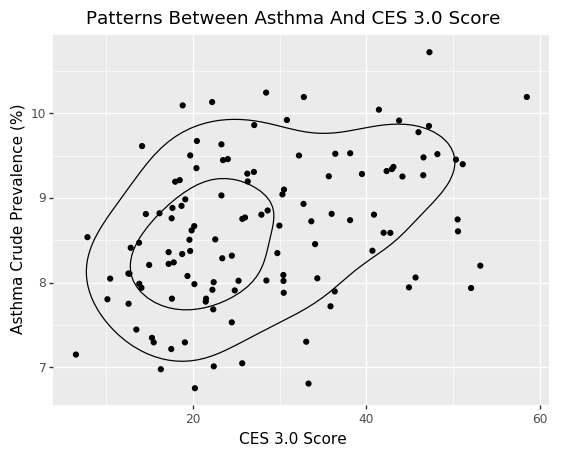

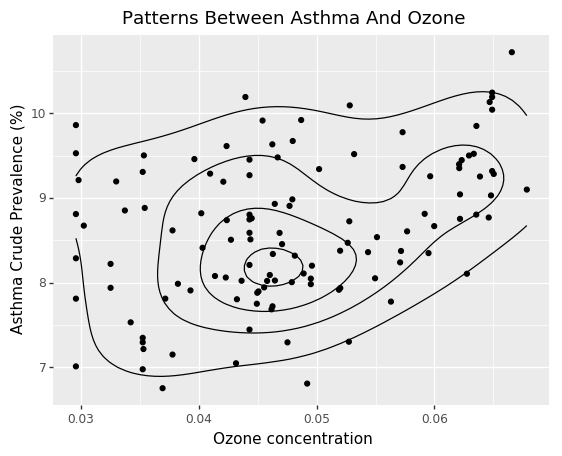

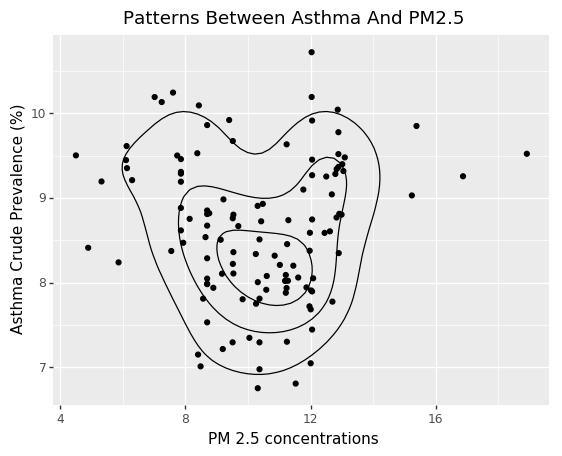

(<ggplot: (7549174890)>,
 <ggplot: (-9223372029305600845)>,
 <ggplot: (-9223372029302851973)>)

In [140]:
p1 = (ggplot(information,aes(x = 'CES 3.0 Score',y = 'CASTHMA_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Asthma And CES 3.0 Score',y = 'Asthma Crude Prevalence (%)'))
p2 = (ggplot(information,aes(x = 'Ozone',y = 'CASTHMA_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Asthma And Ozone',y = 'Asthma Crude Prevalence (%)',x =  'Ozone concentration' ))
p3 = (ggplot(information,aes(x = 'PM2.5',y = 'CASTHMA_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Asthma And PM2.5',y = 'Asthma Crude Prevalence (%)',x = 'PM 2.5 concentrations'))
p1,p2,p3

In [141]:
#Relation between the polution and COPD
linregress(information['COPD_CrudePrev'],information['CES 3.0 Score'])

LinregressResult(slope=4.328161078807903, intercept=5.722570647058909, rvalue=0.3814637617689805, pvalue=1.7180826306938232e-05, stderr=0.9655203847724598)

In [142]:
linregress(information['COPD_CrudePrev'],information['Ozone'])

LinregressResult(slope=0.004238906831388672, intercept=0.02605077096627891, rvalue=0.4245212188454567, pvalue=1.3496481274624327e-06, stderr=0.0008322668256384322)

In [143]:
linregress(information['COPD_CrudePrev'],information['PM2.5'])

LinregressResult(slope=-0.027096783091186474, intercept=10.473410467976567, rvalue=-0.011978684337075166, pvalue=0.8966842384098985, stderr=0.20822671620062858)

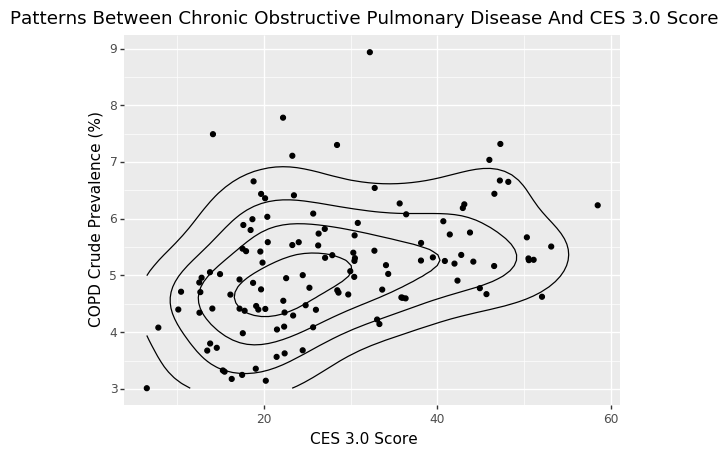

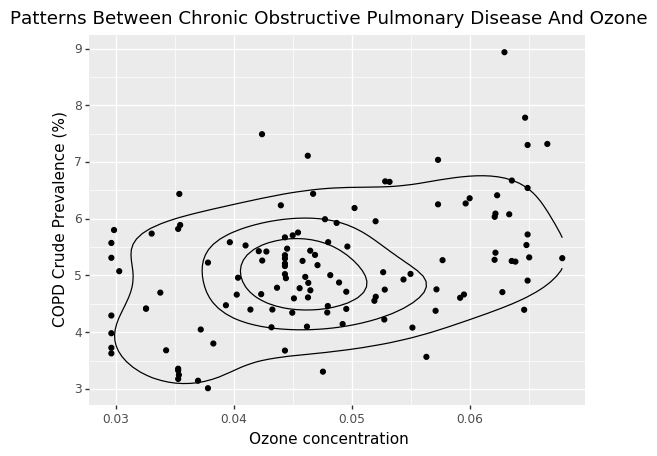

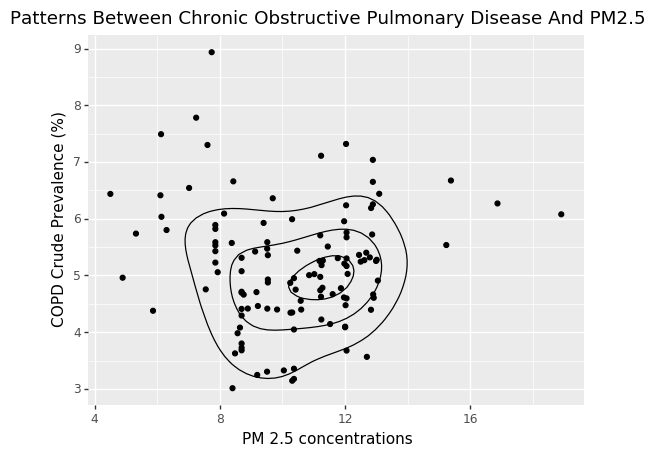

(<ggplot: (7548026646)>,
 <ggplot: (7547892712)>,
 <ggplot: (-9223372029306459574)>)

In [146]:
p4 = (ggplot(information,aes(x = 'CES 3.0 Score',y = 'COPD_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Chronic Obstructive Pulmonary Disease And CES 3.0 Score',y = 'COPD Crude Prevalence (%)'))
p5 = (ggplot(information,aes(x = 'Ozone',y = 'COPD_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Chronic Obstructive Pulmonary Disease And Ozone',y = 'COPD Crude Prevalence (%)',x =  'Ozone concentration' ))
p6 = (ggplot(information,aes(x = 'PM2.5',y = 'COPD_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Chronic Obstructive Pulmonary Disease And PM2.5',y = 'COPD Crude Prevalence (%)',x = 'PM 2.5 concentrations'))
p4,p5,p6

In [148]:
ggsave(p3)

/Users/jie/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/jie/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: plotnine-save-9223372029302851973.pdf
  warn('Filename: {}'.format(filename))
